# Using Country-Level Statistics to Predict Covid-19 Death Count


This project uses the August 9th data from Our World in Data (OWID) Covid-19 dataset (source: https://github.com/owid/covid-19-data/tree/master/public/data) to create a model that predicts the number of total Covid deaths per million using variables such as population density, GDP per capita, and diabetes prevalence by country. 

Let's start with EDA and pre-processing. 

In [264]:
#Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [265]:
# Read dataset from Our World in Data and take a look
owid_df = pd.read_csv("owid-covid-data.csv")
print("number of countries included: " + str(countries_df['location'].nunique()))
print("Dataset dimensions: " + str(owid_df.shape))
owid_df.head()

number of countries included: 209
Dataset dimensions: (35717, 36)


,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


*1. Load your data set. State in one or two sentences what the inclusion and exclusion criteria were for this data set, e.g. from which geographic location and which time period the data were drawn and whether individuals with certain characteristics were deliberately excluded or oversampled.*

Each row in this dataset represents a day's measurement in a particular country of new Covid cases and deaths since the beginning of the pandemic, and includes various country statistics such as life expectancy, hospital beds per thousand, and cardiovascular death rate. This dataset perforce reflects the biases and deficits in each country's Covid data reporting.

Now I'll do some preprocessing and feature engineering to create the final working dataset. 

In [266]:
# some preprocessing, keep relevant columns
countries_df = owid_df.loc[owid_df['date'] == '2020-08-09']
countries_df['smokers'] = (countries_df['female_smokers'] + countries_df['male_smokers']) / 2

countries_df = countries_df[['location', 'population_density', 'median_age', 'gdp_per_capita', 
                        'extreme_poverty', 'diabetes_prevalence', 'smokers', 
                        'handwashing_facilities', 'hospital_beds_per_thousand', 
                        'life_expectancy', 'total_deaths_per_million']]

# find columns with most NaNs
print("Number of NaNs per column: ")
print(countries_df.isna().sum())

Number of NaNs per column: 
location                        0
population_density             11
median_age                     24
gdp_per_capita                 27
extreme_poverty                88
diabetes_prevalence            17
smokers                        71
handwashing_facilities        117
hospital_beds_per_thousand     45
life_expectancy                 3
total_deaths_per_million        0
dtype: int64


In [267]:
#drop columns with most NaNs
covid_df = countries_df.drop(['extreme_poverty', 
                              'handwashing_facilities', 
                              'smokers'], axis=1)

# drop any countries with any remaining NaNs
covid_df = covid_df.dropna(axis='rows')

# reset index as country name
covid_df = covid_df.set_index('location')

# print final dataframe dimensions
print("dataset dimensions: " + str(covid_df.shape))

dataset dimensions: (156, 7)


Although I had to discard 53 of 209 countries because they didn't have enough data, I still have 156 countries in my dataset. 

*2. Divide your data set into two random subsamples of (nearly) equal size. Declare one subsample the training set and the other the test set.*

In [268]:
#Set X and y, split data into training and test set
X = covid_df.drop(['total_deaths_per_million'], axis=1)
y = covid_df['total_deaths_per_million']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

*3. Define the prediction problem. Say which variable is the response and which variables are the predictors. State in which unit each variable is measured, e.g. “life expectancy (years)”. State briefly (one or two sentences) why you think a predictive model outperforms or complements human expertise.*

The response variable is Covid deaths per million population as of today (August 9th), and the features are:

<ol>
<li>Population density (people per km^2)</li>
<li>Median Age (years)</li>
<li>GDP Per Capita (USD)</li>
<li>GDP Per Capita (USD)</li>
<li>Diabetes Prevalence (% of population aged 20 to 79)</li>
<li>Hospital Beds per Thousand People</li>
<li>Life Expectancy (years)</li>
</ol>

This model outperforms human expertise because it can fully process the 156 x 7 matrix. Humans wouldn't be able to extract meaningful observations from a dataset this size without sophisticated visualization techniques. 

*4. For the training set and the test set separately, compute summary statistics (minimum, mean, median, maximum, standard deviation) of the response variable.*

Y Training Set Summary Stats:
count     78.000000
mean     108.501615
std      171.391292
min        0.000000
25%        7.909000
50%       37.284500
75%      110.683500
max      851.624000
Name: total_deaths_per_million, dtype: float64

Y Test Set Summary Stats:
count     78.000000
mean      72.119718
std      127.281590
min        0.000000
25%        3.962000
50%       18.679500
75%       68.581000
max      632.176000
Name: total_deaths_per_million, dtype: float64


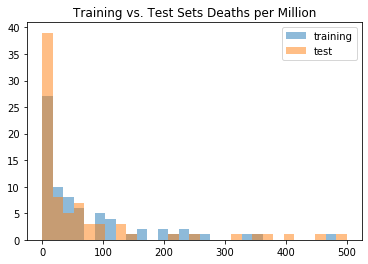

In [269]:
print("Y Training Set Summary Stats:")
print(y_train.describe())
print("\nY Test Set Summary Stats:")
print(y_test.describe())

#plot training vs. test set response variables
bins = np.linspace(0, 500, 30)
pyplot.title("Training vs. Test Sets Deaths per Million")
pyplot.hist(y_train, bins, alpha=0.5, label='training')
pyplot.hist(y_test, bins, alpha=0.5, label='test')
pyplot.legend(loc='upper right')
pyplot.show()

*5. For the training set and the test set separately, report summary statistics (minimum, mean, median, maximum, standard deviation) for all the predictors.*

In [270]:
# print summary statistics for the features' training and test sets
for col in X.columns:
    print('Training Set ' + str(col) + ' Stats:')
    print(X_train[col].describe())
    print('\nTest Set ' + str(col) + ' Stats:')
    print(X_test[col].describe())
    print('-------------------------------------------------\n')

Training Set population_density Stats:
count      78.000000
mean      236.412564
std       900.226857
min         3.202000
25%        26.538250
50%        76.762000
75%       207.139250
max      7915.731000
Name: population_density, dtype: float64

Test Set population_density Stats:
count      78.000000
mean      170.804154
std       284.768987
min         1.980000
25%        45.465500
50%        87.650500
75%       187.597750
max      1935.907000
Name: population_density, dtype: float64
-------------------------------------------------

Training Set median_age Stats:
count    78.000000
mean     33.278205
std       9.019541
min      15.100000
25%      27.350000
50%      33.650000
75%      41.150000
max      48.200000
Name: median_age, dtype: float64

Test Set median_age Stats:
count    78.000000
mean     29.328205
std       8.056133
min      16.400000
25%      23.050000
50%      29.100000
75%      34.700000
max      44.400000
Name: median_age, dtype: float64
---------------------------

*5. (cont'd) Describe in one or two sentences how similar the summary statistics for a given predictor in the training and testing data are. Which predictors exhibit a lot of variation (and thus might be more predictive), which very little?*

I'll compare the average values for each of the training and test set by printing a ratio of the means and seeing how much it deviates from 1. 

In [271]:
# compare means for each feature
for col in X.columns:
    var = X_train[col].mean() / X_test[col].mean()
    print("difference in " + str(col) + " = "+ str(var)[:5])

difference in population_density = 1.384
difference in median_age = 1.134
difference in gdp_per_capita = 1.491
difference in diabetes_prevalence = 0.987
difference in hospital_beds_per_thousand = 1.332
difference in life_expectancy = 1.042


Population density and GDP per capita vary the most, with 33% and 12% differences in mean values. The rest are within one percent of each other. 

### Normalizing the data

The above histogram of deaths per million reveals a highly skewed response variable. And since the scales of the features vary widely (eg GDP per capita @ 10E+5 vs. beds per thousand @ 10E-1), I'll normalize the data. 

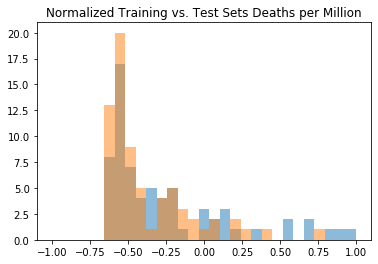

In [275]:
#Normalize the dataframe
normal_df = (covid_df - covid_df.mean()) / covid_df.std()

#reset and resplit X and y
X = normal_df.drop(['total_deaths_per_million'], axis=1)
y = normal_df['total_deaths_per_million']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)

#Histogram of the response variable 
bins = np.linspace(-1, 1, 30)
pyplot.title("Normalized Training vs. Test Sets Deaths per Million")
pyplot.hist(y_train, bins, alpha=0.5, label='training')
pyplot.hist(y_test, bins, alpha=0.5, label='test')
pyplot.show()

*6. Declare your prediction problem to be either a regression problem or a classification problem*

Regression

*7. Fit at least three distinct linear regression models to the training data. All three models should differ along a single well-defined measure of flexibility.*

(see below)


*8. Compute the predictive performance of each model based on the training set and the test set.*

In [283]:
# Function for fitting polynomnial model of specified degree to training data 
# and printing RMSE and r-squared for both training and test data
def create_poly_model(degree):
    poly_features = PolynomialFeatures(degree=degree)
    
    #transform and fit features
    X_train_poly = poly_features.fit_transform(X_train)
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    
    # Run model on both training and test data to see bias/variance tradeoff
    y_train_predicted = poly_model.predict(X_train_poly)
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
    
    # generate results
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)
    print("Degree of the polynomial: {}".format(degree))
    print("RMSE of training set is {}".format(rmse_train))
    print("R2 score of training set is {}".format(r2_train))
    print("RMSE of test set is {}".format(rmse_test))
    print("R2 score of test set is {}".format(r2_test))
    print("-------------------------------------------")
    print("\n")
    return(poly_model)

In [274]:
# Generate 3 models of 1st, 2nd, and 3rd degree polynomials
for degree in range(1, 4):
    create_poly_model(degree)

Degree of the polynomial: 1
RMSE of training set is 0.9738869676547446
R2 score of training set is 0.24859058932288136
RMSE of test set is 0.7860453690904289
R2 score of test set is 0.1124331543376329
-------------------------------------------


Degree of the polynomial: 2
RMSE of training set is 0.816959682902715
R2 score of training set is 0.471237349945297
RMSE of test set is 1.8760924047029401
R2 score of test set is -4.056084165002524
-------------------------------------------


Degree of the polynomial: 3
RMSE of training set is 6.177578874265135e-13
R2 score of training set is 1.0
RMSE of test set is 90.02919663151353
R2 score of test set is -11642.206333096592
-------------------------------------------




*9. Which of the models that you fitted in step 7 would you retain? Justify your choice.*

<br>Model 1, which only includes linear terms of the predictor, performed the best, with an test set RMSE of 0.78 and an r-squared of 0.11. This low r-squared value means that even my best model barely outperforms random chance. I'll investigate this a bit in the postmortem. 

You can also see that the model very quickly overfits the data as you increase the degree of the polynomial. Model 3 almost perfectly fits the training set but misses the test set by about a billion miles.

## Postmortem
An r-squared of 0.11 is still atrocious, so I'm curious to take a peek at the 6 variables individually. First I'll  visualize the relation between the response and each individual feature. I'll print a scatter plot for each displaying feature vs. response (training *and* test data) and showing the r-squared and trendline for the test model. 

In [ ]:
#function that plots for each variable:
#Scatter plot of each feature vs. response (training AND test data) and
#trendline and r-squared for TEST model

def scatter_plot(variable, i):
    regressor = LinearRegression()  
    regressor.fit(X_train[[variable]], y_train)
    y_pred = regressor.predict(X_test[[variable]])
    plt.subplot(2,3,i)
    plt.scatter(normal_df[variable], normal_df['total_deaths_per_million'])
    plt.plot(X_test[[variable]], y_pred, color='blue', linewidth=3)
    plt.title(variable + ' r-squared = '+ str(r2_score(y_test, y_pred))[:5])

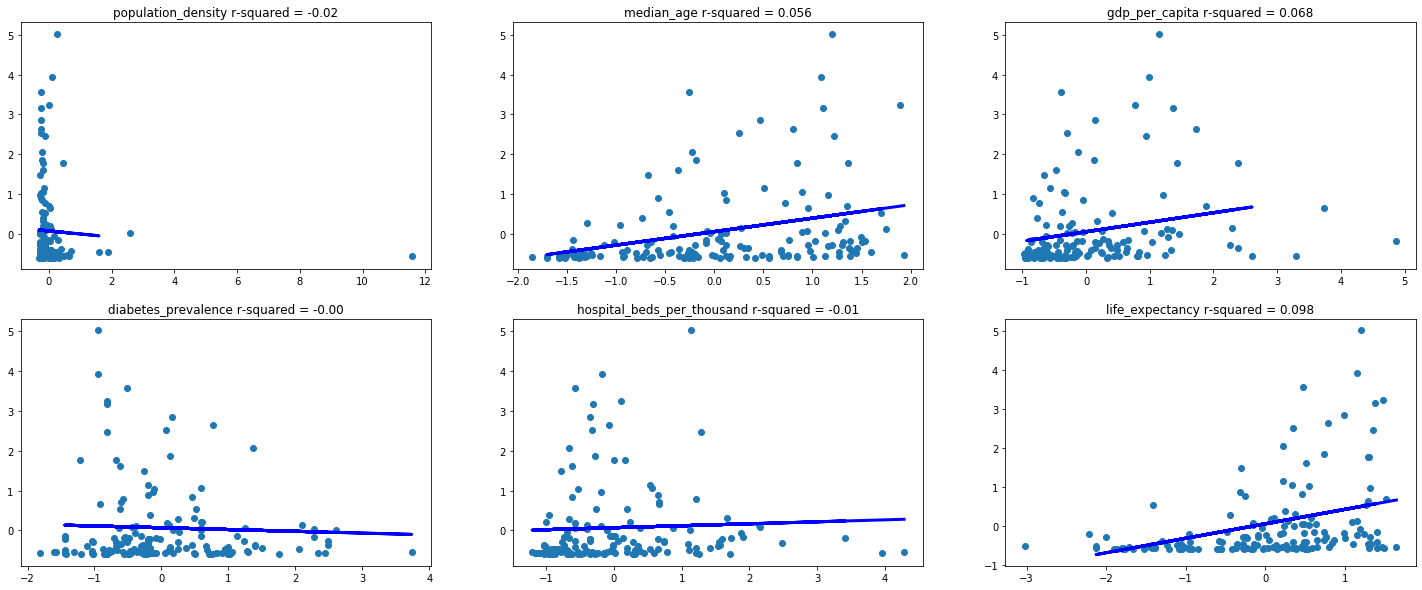

In [279]:
# plot each feature vs total deaths per million
plt.figure(figsize=(25,10))
for col, i in zip((X.columns), range(1,7)):
    scatter_plot(col, i)

Hm, looks like none of the variables have a strong r-squared value. Some of them perform even worse than a straight horizontal trendline (negative r-squared). But high-variability datasets can represent a trend even if they have a low r-squared. I'll check out the model 1 summary next:

In [287]:
# Create and fit linear regression model, print summary
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.273
Model:                                  OLS   Adj. R-squared:                  0.211
Method:                       Least Squares   F-statistic:                     4.433
Date:                      Sun, 09 Aug 2020   Prob (F-statistic):           0.000730
Time:                              13:06:37   Log-Likelihood:                -100.21
No. Observations:                        78   AIC:                             214.4
Df Residuals:                            71   BIC:                             230.9
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

It looks like these 6 variables aren't strong predictors of total deahths per million. This isn't too surprising, since there are many other variables that might predict covid deaths more accurately, such as freedom of the press rating, public acceptance of science, and measures of trust in government, among manay others. A more robust model might incporate these data. 